# Estabilizando rede neurais - Batch Normalization

### Problemas com redes profundas

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn

def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

class Model(nn.Module):
    '''Modelo com n camadas convolucionais.'''
    def __init__(self, num_layers, features):
        super().__init__()
        
        layers = [
            conv3x3(1,features),
            nn.ReLU()
        ]
        for idx in range(1, num_layers):
            layers.append(conv3x3(features,features))
            layers.append(nn.ReLU())
        self.layers = nn.ModuleList(layers)

        self.pool = nn.AdaptiveMaxPool2d(2)
        # Camada linear que recebe features imagens de tamanho 2x2 e gera 10 valores de saída
        self.fc = nn.Linear(features*2*2, 10)

    def forward(self, x):
        acts = []
        for layer in self.layers:
            x = layer(x)
            acts.append(x)
        x = self.pool(x)
        # Transformação das imagens de tamanho bs x features x 2 x 2 para bs x features*2*2
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x, acts
    
model = Model(10, 16)
model

Model(
  (layers): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (17): ReLU()
    (18): Conv2d(16, 16, kernel_siz

Execute a célula abaixo diversas vezes com ctrl+enter. A saída é sempre a mesma!

In [2]:
x = torch.rand(1, 1, 28, 28)
y, acts = model(x)

print(x[0,0,0])
print(y)

tensor([0.8473, 0.6993, 0.6797, 0.8377, 0.5288, 0.7625, 0.5635, 0.6401, 0.9126,
        0.3690, 0.0333, 0.6792, 0.2206, 0.6391, 0.2469, 0.9062, 0.0577, 0.1945,
        0.7032, 0.8367, 0.5065, 0.3833, 0.4205, 0.3516, 0.0329, 0.7910, 0.2805,
        0.3771])
tensor([[ 0.0629, -0.0275,  0.0358, -0.0511,  0.0846, -0.0625, -0.0376, -0.0450,
          0.0303, -0.0785]], grad_fn=<AddmmBackward0>)


A saída da rede é dada apenas pelo bias da última camada:

In [3]:
print(y)
print(model.fc.bias.detach())

tensor([[ 0.0629, -0.0275,  0.0358, -0.0511,  0.0846, -0.0625, -0.0376, -0.0450,
          0.0303, -0.0785]], grad_fn=<AddmmBackward0>)
tensor([ 0.0629, -0.0275,  0.0359, -0.0511,  0.0845, -0.0624, -0.0377, -0.0450,
         0.0303, -0.0786])


Plotando a média e desvio padrão das ativações intermediárias da rede, vemos que os valores caem para zero:

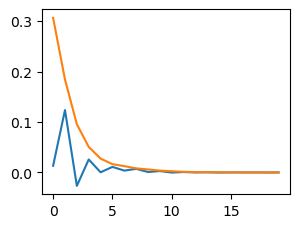

In [4]:
def show_activations(acts):
    act_mean = []
    act_std = []
    for act in acts:
        act = act.detach()
        act_mean.append(act.mean())
        act_std.append(act.std())

    plt.plot(act_mean)
    plt.plot(act_std)

show_activations(acts)

Essencialmente, a operação que uma rede neural faz é dada por:

In [5]:
# Batch de dados
x = torch.rand(10)
# Parâmetros das camadas
weight = 2.
bias = 2.
# 100 camadas
for i in range(100):
    x = (weight*x+bias)
print(x)

tensor([2.6831e+30, 2.5841e+30, 3.2441e+30, 3.3194e+30, 3.0015e+30, 3.2231e+30,
        3.4129e+30, 2.5755e+30, 3.1955e+30, 3.2483e+30])


Tente achar valores de `weight` e `bias` que não levem o valor de x acima a 0, infinito ou algum valor trivial.

### Batch Normalization

Ao normalizarmos os valores, as ativações se tornam bem comportadas!

In [6]:
def normalization(x):
    mean = x.mean()
    std = x.std()
    return (x-mean)/std

x = torch.rand(10)
weight = 20.
bias = -10.
for i in range(10):
    x = (weight*x+bias)
    x = normalization(x)
print(x)

tensor([-0.1140,  0.1620, -0.7996, -1.3525, -0.1127,  0.4383, -1.4303,  1.7541,
         0.9583,  0.4964])


Mas e se a escala dos valores for relevante para a classificação? Por exemplo, talvez um filtro tenda a gerar valores em torno de 10, enquanto que outro filtro gere valores em torno de 0.1. Essa informação será perdida após a normalização.

Uma camada batchnorm permite reescalar os valores caso seja necessário. Os parâmetros de escala são aprendidos durante o treinamento.

In [7]:
class BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Parameter define um tensor com requires_grad=True e que é registrado 
        # como parâmetro treinável do modelo
        self.gamma = nn.Parameter(torch.tensor(1.))
        self.beta = nn.Parameter(torch.tensor(0.))

        self.eps = 1e-5

    def forward(self, x):

        mean = x.mean()
        var = x.var()   # Variância
        # eps evita divisão por 0
        x_norm = (x-mean)/torch.sqrt(var+self.eps)

        # Reescala os valores
        y = self.gamma*x_norm + self.beta

        return y
    
bn = BatchNorm()
bn(100*torch.rand(10))


tensor([-0.9673,  0.0576, -0.4464,  1.7995,  0.0592,  0.4724, -0.8892, -0.0076,
         1.3030, -1.3814], grad_fn=<AddBackward0>)

Mas temos um problema. E quando formos aplicar a rede após o treinamento em uma única imagem? Cada camada terá apenas uma única ativação, o que pode ser um problema. Para evitar isso, durante o treinamento podemos armazenar a média e desvio padrão de todos os batches, e usar a estimativa desses parâmetros de todos os batches para normalizar os valores ao aplicar em uma única imagem.

### Desvendando a camada BatchNorm do Pytorch

In [8]:
# Batchnorm aplicado em 3 canais
bn = nn.BatchNorm1d(3)
print(bn.weight)
print(bn.bias)

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


A longo de vários batches, a camada estima a média e variância dos dados:

In [9]:
for i in range(100):
    # Batches de 4 elementos, 3 canais cada e 6 valores para cada canal
    # Os valores gerados possuem média 4 e variância 9.
    x = torch.normal(mean=4, std=1, size=(4,3,6))
    _ = bn(x)
    print('mean', bn.running_mean)
    #print('var', bn.running_var)



mean tensor([0.3825, 0.4098, 0.4038])
mean tensor([0.7556, 0.7789, 0.7328])
mean tensor([1.0560, 1.1236, 1.0624])
mean tensor([1.3408, 1.3960, 1.3496])
mean tensor([1.6135, 1.6755, 1.6234])
mean tensor([1.8706, 1.9412, 1.8425])
mean tensor([2.0712, 2.1825, 2.0699])
mean tensor([2.2403, 2.3370, 2.2614])
mean tensor([2.4404, 2.4933, 2.4453])
mean tensor([2.6201, 2.6510, 2.5843])
mean tensor([2.7939, 2.7864, 2.7396])
mean tensor([2.9021, 2.8785, 2.8963])
mean tensor([2.9716, 3.0013, 3.0188])
mean tensor([3.0809, 3.1256, 3.1079])
mean tensor([3.1545, 3.2160, 3.1582])
mean tensor([3.2282, 3.3161, 3.2074])
mean tensor([3.3134, 3.4059, 3.3017])
mean tensor([3.3674, 3.4433, 3.3521])
mean tensor([3.4590, 3.4982, 3.4109])
mean tensor([3.5065, 3.5586, 3.4915])
mean tensor([3.5676, 3.5787, 3.5603])
mean tensor([3.6255, 3.6332, 3.6401])
mean tensor([3.6514, 3.6598, 3.6531])
mean tensor([3.6433, 3.6989, 3.7077])
mean tensor([3.6612, 3.7635, 3.7399])
mean tensor([3.6653, 3.7983, 3.7768])
mean tensor(

No modo eval, a média estimada é usada quando a camada for aplicada em novos dados:

In [10]:
# Batch de tamanho 1000 com valores de média 10
# A média do resultado deve ser aproximadamente 10-bn.running_mean
x = torch.normal(mean=10, std=6, size=(1000,3,60))
bn.eval()
y = bn(x)
print(y.mean())

tensor(5.9520, grad_fn=<MeanBackward0>)


Retornando o batchnorm para o modo .train faz com que a camada volte a normalizar pela média e desvio do batch:

In [11]:
x = torch.normal(mean=10, std=6, size=(1000,3,60))
bn.train()
y = bn(x)
print(y.mean())

tensor(7.5022e-09, grad_fn=<MeanBackward0>)
